## Object Detection Evaluation Metric

### 1. Intersection and Union

<img src="image/iou.png" alt="iou" style="width: 500px; float: left;" />

<p>The IOU (Intersection over Union) metric is used to evaluate the overlap between two bounding boxes, requiring two essential elements: the ground truth bounding box and the predicted bounding box. IOU is computed as the ratio of the area of their overlap to the area of union. To evaluate detection, we need to set threshold called IoU threshold which determine how well localization works. If IoU > Threshold = Prediction intersects well with the ground truth.</p> 

### 2. Confidence Score

<img src="image/confidence score.png" alt="confidence score" style="width: 500px; float: left;" />

<p>Probability that bounding box contains object, usually predicted by classifier. Orange box shows good overlap but low confidence score. That is because classifier think that the object inside the bounding box is different object. Blue box shows a bounding box with reasonable overlap and high confidence score. We need to set threshold for confidence score called confidence threshold which refer to the probability of finding an object inside the bounding box.</p>

### 3. Confusion Matrix

True positive: `IoU > IoU threshold` and `confidence score > confidence threshold`
<br />
False positive: `No ground truth bounding box (IoU = 0)` or `IoU < IoU threshold` and `confidence score > confidence threshold`
<br />
`IoU > IoU threshold`, `no bounding box detected near ground truth box` and `confidence score < confidence threshold`
<br />
False negative: `IoU < IoU threshold`, `no bounding box detected near ground truth box/ Not enough overlap` and `confidence score > confidence threshold`
<br />
False negative: `IoU > IoU threshold` and `confidence score < confidence threshold`

### Mean Average Precision (mAP)

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches

In [2]:
# Initialize sample for ground truth, predicted box and confidence score
ground_truth_box = torch.tensor([[8, 12, 352, 498], [10, 15, 450, 500]], dtype = torch.float)

predicted_box = torch.tensor([
    [1.000000, 116.384613, 353.000000, 116.384613], [1.000000, 1.000000, 353.000000, 500.000000],
    [9.000000, 14.000000, 452.500000, 500.500000], [1.000000, 154.846161, 353.000000, 154.846161],
    [196.776474, 231.769226, 196.776474, 231.769226], [1.000000, 116.384613, 353.000000, 116.384613],
    [1.000000, 1.000000, 353.000000, 500.000000], [1.000000, 231.769226, 353.000000, 231.769226],
    [45.000000, 235.230774, 175.000000, 361.230774], [44.500000, 234.230774, 176.000000, 362.230774]
], dtype = torch.float)

confidence_score = torch.tensor([
    0.180000, 0.985000, 0.98000, 0.200000, 0.090000, 0.170000, 0.570000, 0.210000, 0.855000, 0.850000
], dtype = torch.float)

`cv2.rectangle` -> `start point (xmin, ymin), (left, top)`, `end point (xmax, ymax), (right, bottom)`

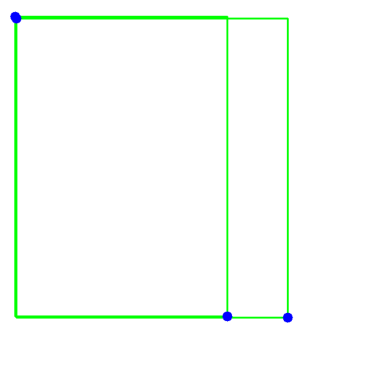

In [3]:
# Visualization of ground truth
# Set random image with width 600 and height 600
image = np.ones((600, 600, 3), dtype = np.uint8) * 255
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

cv2.rectangle(image_rgb, (8, 12), (352, 498), 
                  color = (0, 255, 0), thickness = 2)

cv2.rectangle(image_rgb, (10, 15), (450, 500), 
                  color = (0, 255, 0), thickness = 2)

cv2.circle(image_rgb, (8, 12), radius = 0, color = (0, 0, 255), thickness = 15)
cv2.circle(image_rgb, (352, 498), radius = 0, color = (0, 0, 255), thickness = 15)

cv2.circle(image_rgb, (10, 15), radius = 0, color = (0, 0, 255), thickness = 15)
cv2.circle(image_rgb, (450, 500), radius = 0, color = (0, 0, 255), thickness = 15)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()

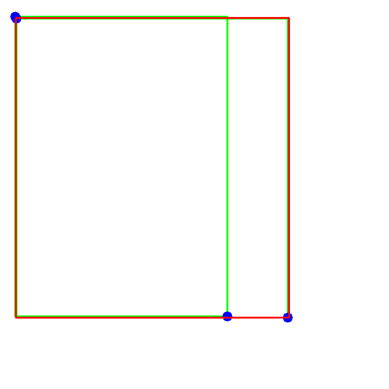

In [4]:
# Visualization of ground truth with predicted box
sample_predicted_box = predicted_box[2]
sample_xmin, sample_ymin, sample_xmax, sample_ymax = int(torch.round(sample_predicted_box[0]).to(torch.int)), int(torch.round(sample_predicted_box[1]).to(torch.int)), \
    int(torch.round(sample_predicted_box[2]).to(torch.int)), int(torch.round(sample_predicted_box[3]).to(torch.int))

image = np.ones((600, 600, 3), dtype = np.uint8) * 255
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

cv2.rectangle(image_rgb, (8, 12), (352, 498), 
                  color = (0, 255, 0), thickness = 2)

cv2.rectangle(image_rgb, (10, 15), (450, 500), 
                  color = (0, 255, 0), thickness = 2)

cv2.circle(image_rgb, (8, 12), radius = 0, color = (0, 0, 255), thickness = 15)
cv2.circle(image_rgb, (352, 498), radius = 0, color = (0, 0, 255), thickness = 15)

cv2.circle(image_rgb, (10, 15), radius = 0, color = (0, 0, 255), thickness = 15)
cv2.circle(image_rgb, (450, 500), radius = 0, color = (0, 0, 255), thickness = 15)

cv2.rectangle(image_rgb, (sample_xmin, sample_ymin), (sample_xmax, sample_ymax), 
                  color = (255, 0, 0), thickness = 2)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()

#### IoU calculation

In [26]:
# Sort based on confidence score
sorted_index = np.argsort(-confidence_score)
sorted_predicted_box = predicted_box[sorted_index, :]

# Initialize true/ false positive
true_positive = torch.zeros((len(sorted_index)), dtype = torch.float64)
false_positive = torch.zeros((len(sorted_index)), dtype = torch.float64)

# If there are not ground true box
if len(ground_truth_box) == 0:
    false_positive = torch.ones((len(sorted_index)), dtype = torch.float64)
# If there are ground true box
else:
    true_positive = torch.zeros((len(sorted_index)), dtype = torch.float64)
    false_positive = torch.zeros((len(sorted_index)), dtype = torch.float64)
    is_obj_already_detected = [False for _ in range(ground_truth_box.shape[0])]
    intersection_threshold = 0.5
    
    for box_number in range(len(sorted_index)):
        get_predicted_box = predicted_box[box_number, :]

        ixmin = torch.max(ground_truth_box[:, 0], get_predicted_box[0])
        iymin = torch.max(ground_truth_box[:, 1], get_predicted_box[1])
        ixmax = torch.min(ground_truth_box[:, 2], get_predicted_box[2])
        iymax = torch.min(ground_truth_box[:, 3], get_predicted_box[3])
        
        width = torch.max(ixmax - ixmin + 1., torch.tensor(0.))
        height = torch.max(iymax - iymin + 1., torch.tensor(0.))
        
        intersection_area = width * height
        
        union = ((get_predicted_box[2] - get_predicted_box[0] + 1.) * (get_predicted_box[3] - get_predicted_box[1] + 1.) +
                 (ground_truth_box[:, 2] - ground_truth_box[:, 0] + 1.) *
                 (ground_truth_box[:, 3] - ground_truth_box[:, 1] + 1.) - intersection_area)
        
        intersection_over_union = intersection_area / union

        is_pass_threshold, max_iou_index = torch.max(intersection_over_union) >= intersection_threshold, \
            torch.argmax(intersection_over_union)
        
        if is_pass_threshold and not is_obj_already_detected[max_iou_index]:
            true_positive[box_number] = 1
            is_obj_already_detected[max_iou_index] = True
        else:
            false_positive[box_number] = 1
            
    true_positive_list = torch.cumsum(true_positive, dim = 0)
    false_positive_list = torch.cumsum(false_positive, dim = 0)
    false_negative_list = ground_truth_box.shape[0] - true_positive
    
    precision = true_positive_list / (false_positive_list + true_positive_list + torch.finfo(torch.float64).eps)
    recall = true_positive_list / (true_positive_list + false_negative_list + torch.finfo(torch.float64).eps)

    average_precision = torch.tensor(0.)
    
    if precision is None or recall is None:
        average_precision = torch.tensor(np.nan)
        
    recall_level = torch.linspace(0, 1, 11)
    
    for level in recall_level:
        recall_check = recall >= level
        print(recall_check)

tensor([True, True, True, True, True, True, True, True, True, True])
tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True])
tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True])
tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True])
tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True])
tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True])
tensor([False, False,  True, False, False, False, False, False, False, False])
tensor([False, False, False, False, False, False, False, False, False, False])
tensor([False, False, False, False, False, False, False, False, False, False])
tensor([False, False, False, False, False, False, False, False, False, False])
tensor([False, False, False, False, False, False, False, False, False, False])


### Reference

https://medium.com/@shroffmegha6695/object-detection-with-deep-learning-beginners-friendly-key-terms-explanation-d4fb594fea83#:~:text=Confidence%20score%20%3A%20A%20score%20which,the%20ground%20truth%20bounding%20box.